In [24]:
from pprint import pprint
import time
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import csv
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Italy Index

In [5]:
italy_df=pd.read_csv("italy_index/FTSE Italia All Share Historical Data.csv")
italy_df.head()

,Date,Price,Open,High,Low,Vol.,Change %,Timestamp
0,2020-3-20,17171.55,17209.93,17628.87,17047.73,1500000000,1.85,1584662400
1,2020-3-19,16859.82,16814.38,17240.13,16438.49,1270000000,2.27,1584576000
2,2020-3-18,16486.21,16372.27,16785.57,16149.48,992760000,-1.17,1584489600
3,2020-3-17,16680.56,16850.34,17238.59,16065.72,1400000000,1.96,1584403200
4,2020-3-16,16360.04,17130.96,17130.96,15498.19,1540000000,-6.06,1584316800


In [8]:
timeseries=italy_df['Price']
print("p-value:",adfuller(timeseries.dropna())[1])

p-value: 0.07486928497033954


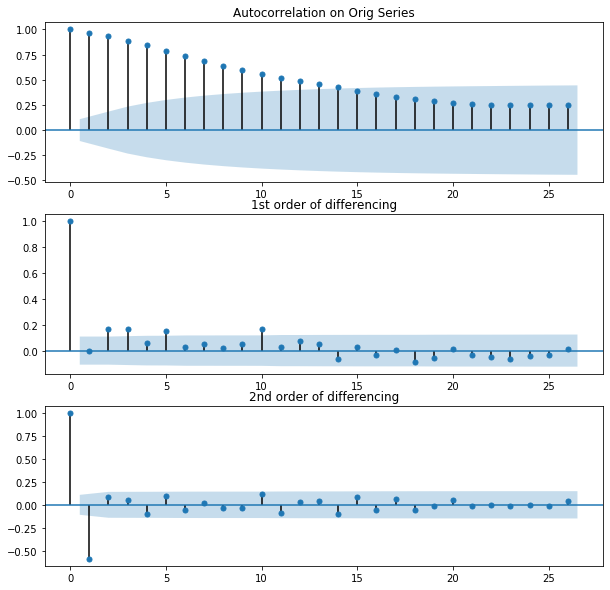

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig=plt.figure(figsize=(10,10))

ax1=fig.add_subplot(311)
fig=plot_acf(timeseries,ax=ax1,
            title='Autocorrelation on Orig Series')
ax2=fig.add_subplot(312)
fig=plot_acf(timeseries.diff().dropna(),ax=ax2,
            title="1st order of differencing")

ax3=fig.add_subplot(313)
fig=plot_acf(timeseries.diff().diff().dropna(), ax=ax3,
            title='2nd order of differencing')


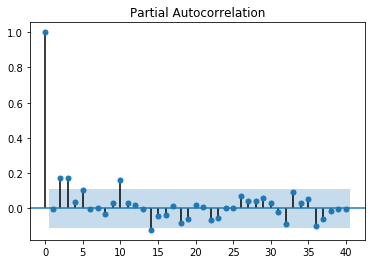

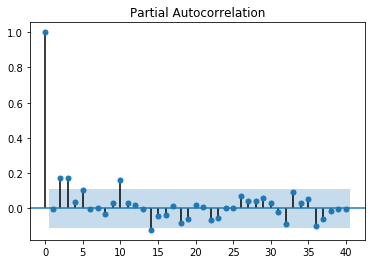

In [13]:
plot_pacf(timeseries.diff().dropna(),lags=40)

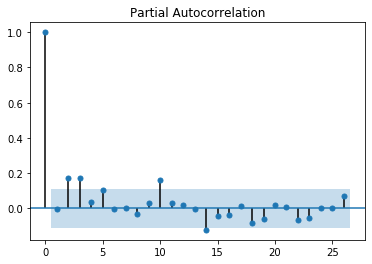

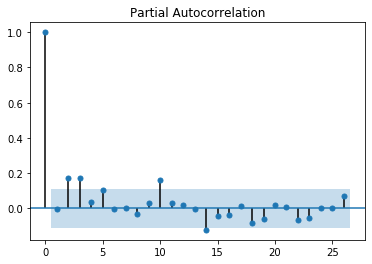

In [14]:
plot_pacf(timeseries.diff().dropna())

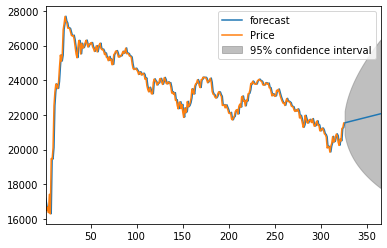

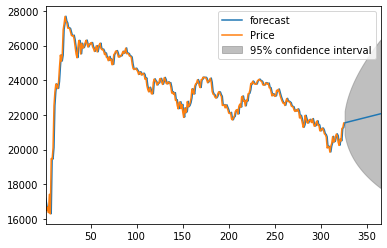

In [42]:
model=ARIMA(timeseries,order=(1,1,0))
results=model.fit()
results.plot_predict(1,365)

C:\Users\nateb\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test MSE: 42684.238


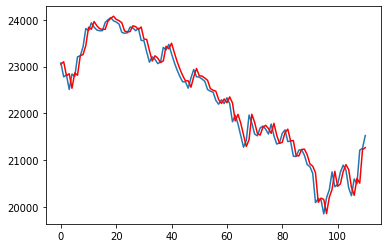

In [40]:
series=italy_df['Price']
X=series.values
size=int(len(X)*.66)
train,test=X[0:size],X[size:len(X)]
history=[x for x in train]
predictions=list()
for t in range(len(test)):
    model=ARIMA(history,order=(1,1,0))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=test[t]
    history.append(obs)
error=mean_squared_error(test,predictions)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

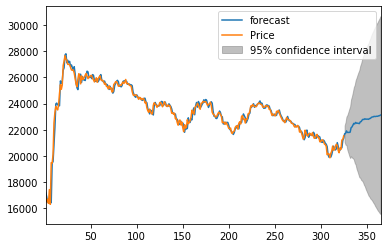

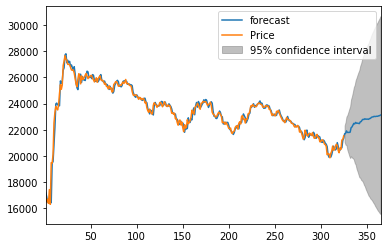

In [43]:
italy_fut=italy_df.drop(['Open','High','Low','Vol.','Change %','Timestamp'],axis=1)
italy_fut['Date']=pd.DatetimeIndex(italy_fut['Date'])
history=italy_fut['Price']
model=ARIMA(history,order=(15,1,0))
model_fit=model.fit()
model_fit.plot_predict(1,365)


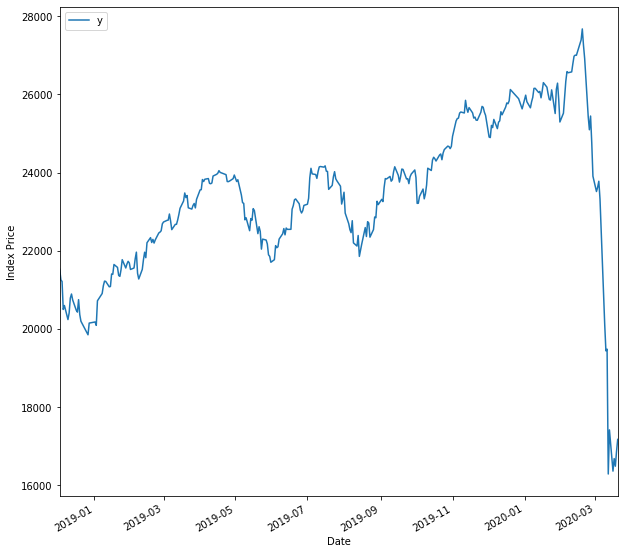

In [37]:
italy_fut=italy_df.drop(['Open','High','Low','Vol.','Change %','Timestamp'],axis=1)

italy_fut['Date']=pd.DatetimeIndex(italy_fut['Date'])

italy_fut=italy_fut.rename(columns={'Date': 'ds',
                                    'Price': 'y'})


ax=italy_fut.set_index('ds').plot(figsize=(10,10))
ax.set_ylabel('Index Price')
ax.set_xlabel('Date')
plt.show()


In [ ]:
my_model=Prophet(interval_width=0.95)
my_model.fit(italy_fut)

future_dates=my_model.make_future_dataframe(periods=60,freq = "day", include_history = True)
future_dates.tail()

forecast=my_model.predict(future_dates)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

my_model.plot(forecast,unceretainty=True)

my_model.plot_components(forecast)

# S&P 500

In [ ]:
curr_time = int(time.time())
prior_year = curr_time-(60*60*24*365)
ticker_symbol = "^GSPC"

In [ ]:

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "c9571a29b7msh7dedf518d9ba8b2p1bf4b5jsnec4ec11b7588"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

In [ ]:
timestamp = response.json()['chart']['result'][0]['timestamp']
year_close = response.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

    
snpDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
snp_df = pd.DataFrame(snpDict)

snp_df['Change %'] = ((snp_df['Close']-snp_df['Open'])/snp_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(snp_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(snp_df['Timestamp']))]
snp_df['Date'] = convert_date


snp_df['Last Year'] =[datetime.datetime.strptime(snp_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(snp_df['Date']))]

snp_df

In [ ]:
series=snp_df['Change %']
X=series.values
size=int(len(X)*.66)
train,test=X[0:size],X[size:len(X)]
history=[x for x in train]
predictions=list()
for t in range(len(test)):
    model=ARIMA(history,order=(5,1,0))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=test[t]
    history.append(obs)
error=mean_squared_error(test,predictions)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

# SSE Index (Shanghai)

In [ ]:
ticker_symbol = "^SSEC"
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "c9571a29b7msh7dedf518d9ba8b2p1bf4b5jsnec4ec11b7588"
    }

response_ssec = requests.request("GET", url, headers=headers, params=querystring)

In [ ]:
timestamp = response_ssec.json()['chart']['result'][0]['timestamp']
year_close = response_ssec.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response_ssec.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response_ssec.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response_ssec.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

ssec_Dict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
ssec_df = pd.DataFrame(ssec_Dict)

ssec_df['Change %'] = ((ssec_df['Close']-ssec_df['Open'])/ssec_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(ssec_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(ssec_df['Timestamp']))]
ssec_df['Date'] = convert_date


ssec_df['Last Year'] =[datetime.datetime.strptime(ssec_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(ssec_df['Date']))]

ssec_df

# Dow Jones Index

In [ ]:
ticker_symbol = "^DJI"
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "c9571a29b7msh7dedf518d9ba8b2p1bf4b5jsnec4ec11b7588"
    }

response_DJI = requests.request("GET", url, headers=headers, params=querystring)

In [ ]:
timestamp = response_DJI.json()['chart']['result'][0]['timestamp']
year_close = response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response_DJI.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

dji_Dict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
dji_df = pd.DataFrame(dji_Dict)

dji_df['Change %'] = ((dji_df['Close']-dji_df['Open'])/dji_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(dji_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(dji_df['Timestamp']))]
dji_df['Date'] = convert_date


dji_df['Last Year'] =[datetime.datetime.strptime(dji_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(dji_df['Date']))]


dji_df

In [ ]:
series=dji_df['Change %']
X=series.values
size=int(len(X)*.66)
train,test=X[0:size],X[size:len(X)]
history=[x for x in train]
predictions=list()
for t in range(len(test)):
    model=ARIMA(history,order=(5,1,0))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=test[t]
    history.append(obs)
error=mean_squared_error(test,predictions)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

# COVID19_Data

In [ ]:
time_series_2019_ncov_Deaths =pd.read_csv("COVID19_data/time_series_2019-ncov-Deaths.csv")
time_series_2019_ncov_Recovered = pd.read_csv("COVID19_data/time_series_2019-ncov-Recovered.csv")
time_series_ncov_Confirmed = pd.read_csv("COVID19_data/time_series-ncov-Confirmed.csv")
time_series_ncov_Deaths = pd.read_csv("COVID19_data/time_series-ncov-Deaths.csv")
time_series_2019_ncov_Confirmed = pd.read_csv("COVID19_data/time_series_2019-ncov-Confirmed.csv")
time_series_2019_ncov_Recovered = pd.read_csv("COVID19_data/time_series_2019-ncov-Recovered.csv")
